# Writing Shakespeare with RNNs
By Karl Heyer

In this project we're going to train a character level RNN on the collected works of Shakespeare, and use it to write some Shakespeare of our own. The Shakespeare corpus used for training was made available by [Project Gutenberg](https://www.gutenberg.org/files/100/100-0.txt).

## Contents

1. Model Architecture
2. Project Setup
    * 2.1 Import Libraries
    * 2.2 Data Overview
3. Model Training
4. Model Parameter Tuning

# 1. Model Architecture

This project will use a recurrent neural network (RNN) to build a character model. Lets break down what these mean.

## Character Model

This model will try to predict the next single character in a string of characters. For example, if the last sequence of characters the RNN has seen are "tomorro", it should predict "w" as the next character.

This is different from a word level model that tries to predict whole words with every step.

## Recurrent Neural Network

Most deep learning architectures have a series of layers that process an input into an output. Each layer has a set of weights that perform some functional operation to convert inputs to outputs. RNNs, rather than having a deep stack of layers, have a single hidden layer that is updated every time an input comes in. This allows the activations of a previous input to affect the activations of the next input. This allows RNNs to learn complex relationships along a series of inputs.

This has made RNNs very effective architectures for NLP problems, where understanding a word in a sentence requires understanding what came before it.

For example, lets say the RNN is processing the word "thanks". Since this is a character level model, each character is fed into the network one at a time.

First the network processes "t", and updates the hidden state accordingly.
Then the network processes "h", using the activations generated by the previous letter, "t", to process "h" and generate a new set of activations.
Then the network processes "a", using the activations generated by "h" and "t". And so on.

In Pytorch, the standard RNN module processes each input into a new set of activations using the following equation:

$h_t = tanh(w_{ih} x_t + b_{ih}  +  w_{hh} h_{(t-1)} + b_{hh})$

The network starts with an existing hidden state $h_{(t-1)}$. When a new input $x_t$ enters the network, it is processed by a linear layer with weights $w_{ih}$ and bias $b_{ih}$. The hidden state $h_{(t-1)}$ is also processed by a linear layer with weights $w_{hh}$ and bias $b_{hh}$. The outputs of these two linear layers are summed together and processed by the $tanh$ activation function to create the new hidden state $h_t$.

For this project, we'll use a more advanced version of an RNN called an LSTM. The key improvement of LSTMs over regular RNNs is LSTMs introduce a set of gates that control how much information from the old hidden state and the current input move into the new hidden state. The parameters that control these gates are learned by the network. This allows LSTMs to learn and understand information over longer periods.

The equations governing LSTMs:

$\begin{array}{ll}
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
c_t = f_t c_{(t-1)} + i_t g_t \\
h_t = o_t \tanh(c_t)
\end{array}$

$i_{t}$ is the input gate. This controls how much of the new input is taken into the cell state.

$f_{t}$ is the forget gate. This gate controls how much of the old cell state passes on to the new cell state.

$g_{t}$ is the cell gate, which is the same equation we used to define our new hidden state in the standard RNN.

$o_{t}$ is the output gate which controls how much of the cell state passes on to the hidden state.

$c_{t}$ is the current cell state. You will notice $c_{t}$ is composed of the old cell state, the current forget gate, the current input gate, and the current cell gate. This shows how the various gates are used to filter how much of the input and previous cell state pass on to the new hidden state.

$h_{t}$ is the new hidden state. It is composed of the current cell state activated by $tanh$ and filtered by the output gate.

Visually:[](attachment:LSTM.png)

<img src="LSTM.png">


When the optimizer updates the weights by backpropagation, the loss is propagated through all the hidden activations, essentially "unrolling" the hidden state into each set of activations created over the course of generating the final activations.

Visually:[](attachment:RNN.png)

<img src="RNN.png">

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



This leads to one of the most important parameters in training RNNs: backprop through time (bptt). The bptt value sets how many hidden activations are saved and propagated through during backpropagation. Bptt is a double edged sword - on the one hand, a larger bptt value allows the network to train over longer sequences. This can allow the network to understand language over a longer sequence length. On the other, the larger the bptt value, the deeper the network becomes and the harder it is to train. 



# 2. Project Setup

## 2.1 Load Libraries

This project uses FastAI, Pytorch, and their associated dependencies.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_data import *
from torchtext import vocab, data
from fastai.nlp import *
from fastai.lm_rnn import *

In [2]:
#Set GPU
torch.cuda.set_device(1)
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

## 2.2 Data Overview

Our corpus is a single text file containing the complete works of Shakespeare

In [4]:
PATH='data/Shakespeare/'

In [5]:
text = open(f'{PATH}Shakespeare.txt', encoding='utf-8').read()
print('corpus length:', len(text))

corpus length: 5662616


In [44]:
print(text[4000000:4001000])

or love
    As for another secret close intent
    By marrying her which I must reach unto.
    But yet I run before my horse to market.
    Clarence still breathes; Edward still lives and reigns;
    When they are gone, then must I count my gains.         Exit

SCENE 2.

London. Another street

Enter corpse of KING HENRY THE SIXTH, with halberds to guard it;
LADY ANNE being the mourner, attended by TRESSEL and BERKELEY

  ANNE. Set down, set down your honourable load-
    If honour may be shrouded in a hearse;
    Whilst I awhile obsequiously lament
    Th' untimely fall of virtuous Lancaster.
    Poor key-cold figure of a holy king!
    Pale ashes of the house of Lancaster!
    Thou bloodless remnant of that royal blood!
    Be it lawful that I invocate thy ghost
    To hear the lamentations of poor Anne,
    Wife to thy Edward, to thy slaughtered son,
    Stabb'd by the self-same hand that made these wounds.
    Lo, in these windows that let forth thy life
    I pour the helpless ba

Looks like Shakespeare.

Since this is a character model, the model vocabulary will be every character type that appears in the corpus. It looks like we have 94 characters in the corpus. We will also add a "\0" value for padding.

In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 94


In [7]:
chars.insert(0, "\0")

''.join(chars[1:-6])

'\t\n !"&\'()*,-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]_`abcdefghijklmnopqrstuvwxyz|}Æà'

To create a train and validation set, we don't want to randomly shuffle or select data the way we would with other types of data. This is because we want to preserve the text/sentence structure, because that's exactly what we want the model to learn!

A simple way to do this is to put the last 20% of the text into the validation set, and train on the first 80%.

In [8]:
PATH='data/Shakespeare/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

os.listdir(f'{PATH}')

['models', 'Shakespeare.txt', 'tmp', 'trn', 'val']

In [15]:
with open('data/Shakespeare/Shakespeare.txt', encoding='utf-8') as f:
    text = f.readlines()
    text_line_length = len(text)
    trn_index = int(text_line_length*.8)
    trn = text[:trn_index]
    tst = text[trn_index:]
    with open('data/Shakespeare/trn/trn.txt','w', encoding='utf-8') as f2:
        f2.writelines(trn)
    with open('data/Shakespeare/val/val.txt','w', encoding='utf-8') as f3:
        f3.writelines(tst) 

# 3. Model Training

This is where we define the data loader for the model. 

TEXT is a torchtext field object. This contains the tokenization fuction used to process the text for the model. Since this is a character level model, the tokenizer is just the list function (ie 'abcd' --> ['a', 'b', 'c', 'd'])

bs is the batch size and bptt is the backprop through time value. These two values decide how the text corpus is split up and fed into the model. Our batch size is 64, so the corpus is split into 64 equal sized sections. Bptt is 16. This is the depth of text taken in each minibatch from the corpus after it has been split by the batch size. This means the batch fed to the GPU will be 16x64, with each column representing 16 characters occurring in sequence.

n_fac sets the size of the embedding matrix for each character in the vocabulary. 

n_hidden sets the size of the hidden layer.

In [34]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=16; n_fac=32; n_hidden=512

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(4331, 61, 1, 4436228)

In [35]:
em_sz = n_fac  # size of each embedding vector
nh = n_hidden     # number of hidden activations per layer
nl = 2       # number of layers

We will use the Adam optimizer to train the model.

The model itself has 5 dropout parameters.

dropouth is applied to the activations going from one LSTM block to another.

dropouti is applied to the input layer.

dropoute is applied to the embedding layer.

wdrop is applied to the LSTM's hidden weights.

dropout is applied to the linear decoder that determines the final prediction.

In [36]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [37]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.1, dropout=0.1, wdrop=0.2, dropoute=0.04, dropouth=0.1)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

This is the model structure. We start with an embedding matrix encoding our vocabulary. Then we have two LSTM modules, followed by a linear decoder.

In [39]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(61, 32, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(61, 32, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(32, 512)
      )
      (1): WeightDrop(
        (module): LSTM(512, 32)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=32, out_features=61, bias=False)
    (dropout): LockedDropout(
    )
  )
)

We select an optimum learning rate and proceed with training the model using stochastic gradient descent with restarts 

 96%|████████████████████████████████████████████████████████████████▏  | 4149/4331 [00:48<00:02, 85.28it/s, loss=7.49]

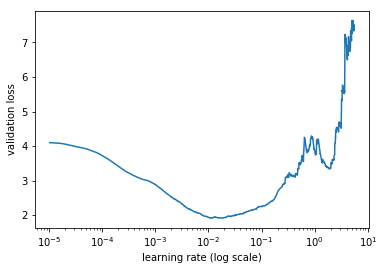

In [40]:
learner.lr_find(wds=1e-5)
learner.sched.plot()

In [41]:
learner.fit(1e-2, 2, wds=1e-5)

epoch      trn_loss   val_loss                                                                                         
    0      1.727611   1.718276  
    1      1.695116   1.68495                                                                                          


[array([1.68495])]

epoch      trn_loss   val_loss                                                                                         
    0      1.672177   1.693811  


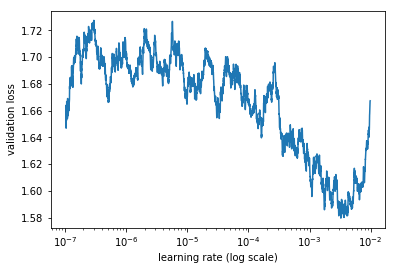

In [42]:
learner.lr_find(start_lr = 1e-7, end_lr = 1e-2, wds=1e-5)
learner.sched.plot()

In [43]:
learner.fit(1e-3, 3, wds=1e-5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.571616   1.590236  
    1      1.557302   1.56775                                                                                          
    2      1.531545   1.555178                                                                                         
    3      1.531927   1.553549                                                                                         
    4      1.509142   1.537642                                                                                         
    5      1.497171   1.522563                                                                                         
    6      1.487526   1.519209                                                                                         


[array([1.51921])]

So our model's validation loss is about 1.51. What does this actually look like?

In [45]:
def sample_model(m, s, l=50):
    t = TEXT.numericalize(s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...')

    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
        word = TEXT.vocab.itos[to_np(r)[0]]
        res, *_ = m(r[0].unsqueeze(0))
        print(word, end='')
    m[0].bs=bs

In [46]:
m = learner.model
m.eval()
sample_model(m, "Good, speak to the mariners: fall to't, yarely", l=1000)

...
 you can in, let he treft the sport rosper!who sing you princess fetch. refuse you will know:_break your gfgalianes know ourgree4behold; and not he thinch.            demeans the feace near wto indeed, all these;  for ever at said i envire in the yuty; he did dution    in gar5 marry, go a9hood from money.  iago. reason picpets; for he comes the great stood.      king us no surrey    that have not psrupks lik’d me dnines,'  with fool, possession. 6lweet dropping, said to mught come for thine husband spoke,send it a zoque. sek'st,    and viadwhich his princers and like of his sport of rest;the fman-toa sings.d servant.’ the days must gaved him that i think not not fo4 out again?air thas ehe were that you would brief all and counsel,power to starching guirts; yet'ss lidy,and he are me nature were to thee this will he were to   resimming only so the devil at equire to tongue.    'gainst me, by this, she dare with his dad itself. these done.let, my soul, that most bad —here is not a' th

So this isn't half bad for just a few epochs of training. Most of the words spelled are real words. The model has learned basic spelling and punctuation.

But it's far from perfect. Some of the words have extra letters or even a number stuck in them. A few of the "words" look like someone smashing their keyboard. The model misses spaces sometimes.

Most importantly, the whole sentences put out by the model don't make much sense. Some are pretty good. Some have a few sensible chunks but are otherwise meaningless. Some are just word vomit. Lets train the model a bit more and see if it gets better.

In [47]:
learner.fit(1e-3, 3, wds=1e-5, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.492737   1.521873  
    1      1.478275   1.507722                                                                                         
    2      1.503903   1.518509                                                                                         
    3      1.474764   1.499336                                                                                         
    4      1.456297   1.491309                                                                                         
    5      1.451991   1.485613                                                                                         
    6      1.488442   1.505487                                                                                         
    7      1.471747   1.507714                                                                                         
    8  

[array([1.4664])]

In [48]:
m = learner.model
m.eval()
sample_model(m, "Good, speak to the mariners: fall to't, yarely", l=1000)

...
.  peay6your king-here must she virtue.  gloucester. i do remember it is them.  ilas. hasthis so writing villain's son    as gentlemen with love at is thy s0boulp to do up a and hisade-several thank    good hiljures of witness.  nerissa. am i heard the court actionraoes on?  [unbrawledge sent of the bonds' houseenter gremio, isficy his sons. but the high crumpets are      as sworn at all in my tardiness and this holy blood?  somerset. o whe'er he was done and look    out of the heart, and me with suddstracge _henry,      good antony's enrivous natures, and i have server    for.  attended. i have say me name.    i'll find thy outlary trumpet in the    bnack with none.  boyet. what, says.  angelo. to the merry it my course.  gloucester. upon portly, who mores and wear with his pess'd    away, let mischance live all you, !  lafeu. ley me barren, the poet of single blood left white,    i dore to d if henry tald and devise so fair face:    both of offendest sweet wrongs in fearance,    

This looks a bit better. All the problems we identified before are still present, but the writing seems a little clearer.

# 4. Model Parameter Tuning

Lets see if the model improves with more weights to learn on and a higher bptt value. Note the model will need slightly higher dropout parameters to account for the increased complexity.

In [100]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=94; n_fac=74; n_hidden=1024

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(736, 61, 1, 4436228)

In [101]:
em_sz = n_fac  # size of each embedding vector
nh = n_hidden     # number of hidden activations per layer
nl = 2       # number of layers

In [102]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [114]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.11, dropout=0.11, wdrop=0.22, dropoute=0.05, dropouth=0.11)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [115]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(61, 74, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(61, 74, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(74, 1024)
      )
      (1): WeightDrop(
        (module): LSTM(1024, 74)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=74, out_features=61, bias=False)
    (dropout): LockedDropout(
    )
  )
)

 85%|██████████████████████████████████████████████████████████▉          | 628/736 [00:40<00:06, 15.55it/s, loss=6.94]

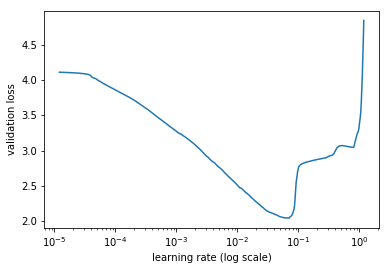

In [116]:
learner.lr_find(wds=1e-5)
learner.sched.plot()

In [117]:
learner.fit(1e-2, 2, wds=1e-5)

epoch      trn_loss   val_loss                                                                                         
    0      1.591826   1.605265  
    1      1.528446   1.549812                                                                                         


[array([1.54981])]

epoch      trn_loss   val_loss                                                                                         
    0      1.464652   1.5462    


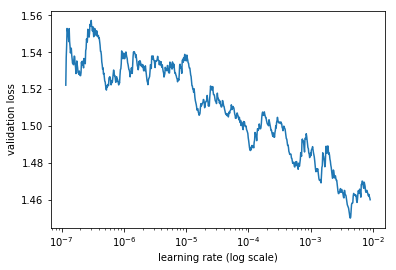

In [118]:
learner.lr_find(start_lr = 1e-7, end_lr = 1e-2, wds=1e-6)
learner.sched.plot()

In [119]:
learner.fit(1e-3, 3, wds=1e-5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.416902   1.496197  
    1      1.411221   1.479023                                                                                         
    2      1.41721    1.472344                                                                                         
    3      1.393495   1.466721                                                                                         
    4      1.408795   1.457604                                                                                         
    5      1.383943   1.451081                                                                                         
    6      1.379116   1.449694                                                                                         


[array([1.44969])]

It looks like the model is still training well despite the high bptt value. I was a little nervous setting it so high would make the model unstable.

Right now our loss is comprable to where we tested the previous model. Lets see if the increased bptt results in better results at the same loss

In [120]:
m = learner.model
m.eval()
sample_model(m, "Good, speak to the mariners: fall to't, yarely", l=1000)

...
 sayor sox,    die, or embraces the merry clock,  men thhouldst one kind lack'd.      ;    give me the true than 'mind.  gratiano. never love thy faith, revenge, and four i would be think,    and with her atsend beastly to <pad>dost not    have thee down adieu. i could rome me with this —hand.    when you shall hinding the |be made alns    to expect kindred at those clouds?    dear soul commend a it, sir, but knows hrock our son upon't.      enter hostess falstaff, how seft them heary  chesture. i'll had more unhand'st thou young condition    wlifted i cannot be your face, above it this beds,    and there is so, tucked not. sir, je her that lock'd    pistol’s wonder.      claudio.      thf near trees let me more than his soul, and dismiss to attend, and    is not bemar'd in every water more flesh?    most dangerous lancaster! a season is true g[exeunt,    thou hast as my wife, entertain'd no peoplation of gone?  queen margaret. it is everrop me; and show me to reputation shall    h

There doesn't seem to be an obvious effect.

Lets see where we can take this thing

In [121]:
learner.fit(1e-3, 1, wds=1e-5, cycle_len=8)

epoch      trn_loss   val_loss                                                                                         
    0      1.401475   1.456862  
    1      1.409504   1.45804                                                                                          
    2      1.418249   1.454282                                                                                         
    3      1.41346    1.447059                                                                                         
    4      1.377535   1.441778                                                                                         
    5      1.383288   1.436579                                                                                         
    6      1.379151   1.432865                                                                                         
    7      1.384822   1.432204                                                                                         


[array([1.4322])]

epoch      trn_loss   val_loss                                                                                         
    0      1.446892   1.490283  


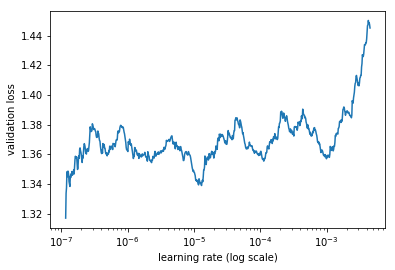

In [122]:
learner.lr_find(start_lr = 1e-7, end_lr = 5e-3, wds=1e-5)
learner.sched.plot()

In [123]:
learner.fit(1e-3, 3, wds=1e-5, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.394752   1.437348  
    1      1.365708   1.426488                                                                                         
    2      1.386582   1.435977                                                                                         
    3      1.367376   1.425626                                                                                         
    4      1.365785   1.414676                                                                                         
    5      1.337672   1.410251                                                                                         
    6      1.357537   1.424629                                                                                         
    7      1.347785   1.419795                                                                                         
    8  

[array([1.38525])]

In [124]:
learner.fit(5e-4, 3, wds=1e-5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.30772    1.385649  
    1      1.315219   1.388525                                                                                         
    2      1.302933   1.380702                                                                                         
    3      1.322117   1.388485                                                                                         
    4      1.307799   1.38148                                                                                          
    5      1.285954   1.376051                                                                                         
    6      1.297857   1.374518                                                                                         


[array([1.37452])]

In [125]:
learner.fit(1e-4, 3, wds=1e-5, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.30019    1.374921  
    1      1.29081    1.373529                                                                                         
    2      1.290133   1.374781                                                                                         
    3      1.293029   1.373103                                                                                         
    4      1.283037   1.371363                                                                                         
    5      1.291287   1.371827                                                                                         
    6      1.277303   1.372734                                                                                         
    7      1.287638   1.372599                                                                                         
    8  

[array([1.36832])]

In [126]:
m = learner.model
m.eval()
sample_model(m, "Good, speak to the mariners: fall to't, yarely", l=3000)

...
, i will bishop you    but where suke good.  macbeth. but a fear and truely power to have thy will;    iqone tohnstusion of this hand of siwardity.                  exit  lucius. how choice it he should be?    cowardly pyramus got upon my pardon    and deliver every thee coppeted.    his swagger'd sparty of defators, or another    cudgelled modest of th' actionness; thou shalt see    a palmer word done he.    we fight to any good health, or else also,    that their fruitful gentlemen doth patient last;    and not dislike for learning under plenzy;    and all protector is in measured and    whether 'a procedent hath nor very pudking.    my death, and murder, one. they presently go alone.    if they have named it.                                                 ;                widows the wary states  messenger. by this passy of a scone that hangs your son,    to bar him, whose reigntroy shall be rich motion    for does of lady such as a garland    to th' vhry, in defection boast it 

In [128]:
learner.save('shakespeare')

## Conclusions

At a validation loss of 1.36 the model looks a better. After the final epoch the model was definitely struggling to train. Epoch gains were coming in the hundredths. The model was somewhat over fit at the end of training.

There were a number of things I tried to improve on the model that did not pan out.
I found I could surpress the overfitting tendancy by increasing dropout and weight decay, but the model struggled to train to the same accuracy, and subsequently performed worse.

I tried adding a third LSTM layer but that model failed to train. I expect at that point the network was just too deep.

More work could be done to find truly optimum hyperparameters for the layer sizes and bptt values. I did a brief search of parameters and found that increasing layer sizes resulted in more overfitting without any real gain.

This was a good project to become better acquainted with RNNs. Having to really think about how the LSTM gates were moving tensors around helped to make RNNs less of a black box. Next I'm going to try a word level RNN.